In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import re
import seaborn

%matplotlib inline
plt.style.use('ggplot')

mpl.rcParams['figure.figsize'] = (12, 12)

In [3]:
memcdf = pd.read_csv('./data/memcpy.csv', sep = ',')

In [4]:
memcdf.head()

,size,dsetmatrix,cudaMemcpy,chunktime,chunk_nosync,chunktimestream,chunkstreams_ nosync,chunkno,chunksize,streams,totchunks,Single Stream Chunking nosync,Stream Chunking,Stream Chunking nosync,Stream Chunk size
0,128,0.064941,0.050049,0.067871,0.037842,0.076904,0.047852,1,32768,4,4,0.756099,1.536574,0.956103,32768.0
1,128,0.053223,0.038818,0.043945,0.036865,0.068848,0.046875,1,32768,4,4,0.949688,1.773610,1.207558,32768.0
2,128,0.052002,0.039062,0.043701,0.036865,0.070068,0.048828,1,32768,4,4,0.943756,1.793764,1.250013,32768.0
3,128,0.058105,0.036865,0.043213,0.036133,0.070068,0.048096,1,32768,4,4,0.980144,1.900665,1.304652,32768.0
4,128,0.058838,0.045166,0.042969,0.036865,0.077148,0.048828,1,32768,4,4,0.816211,1.708099,1.081079,32768.0


In [5]:
memcdf['cudaMemcpy'][memcdf['size']==128].mean()

0.039188

In [6]:
size=memcdf['size'].unique()
for s in size:
    avg=memcdf['cudaMemcpy'][memcdf['size']==s].mean()
    memcdf.loc[memcdf['size']==s, 'Single Stream Chunking nosync'] = memcdf['chunk_nosync'].apply(lambda x: x/avg)
    memcdf.loc[memcdf['size']==s, 'Stream Chunking'] = memcdf['chunktimestream'].apply(lambda x: x/avg)
    memcdf.loc[memcdf['size']==s, 'Stream Chunking nosync'] = memcdf['chunkstreams_ nosync'].apply(lambda x: x/avg)

memcdf.head()

,size,dsetmatrix,cudaMemcpy,chunktime,chunk_nosync,chunktimestream,chunkstreams_ nosync,chunkno,chunksize,streams,totchunks,Single Stream Chunking nosync,Stream Chunking,Stream Chunking nosync,Stream Chunk size
0,128,0.064941,0.050049,0.067871,0.037842,0.076904,0.047852,1,32768,4,4,0.965653,1.962437,1.221088,32768.0
1,128,0.053223,0.038818,0.043945,0.036865,0.068848,0.046875,1,32768,4,4,0.940722,1.756864,1.196157,32768.0
2,128,0.052002,0.039062,0.043701,0.036865,0.070068,0.048828,1,32768,4,4,0.940722,1.787996,1.245994,32768.0
3,128,0.058105,0.036865,0.043213,0.036133,0.070068,0.048096,1,32768,4,4,0.922042,1.787996,1.227314,32768.0
4,128,0.058838,0.045166,0.042969,0.036865,0.077148,0.048828,1,32768,4,4,0.940722,1.968664,1.245994,32768.0


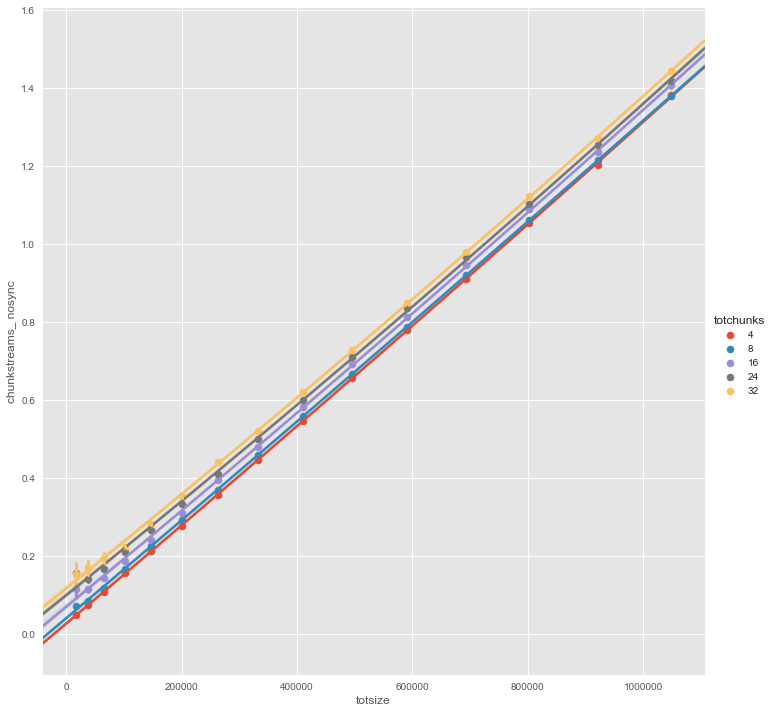

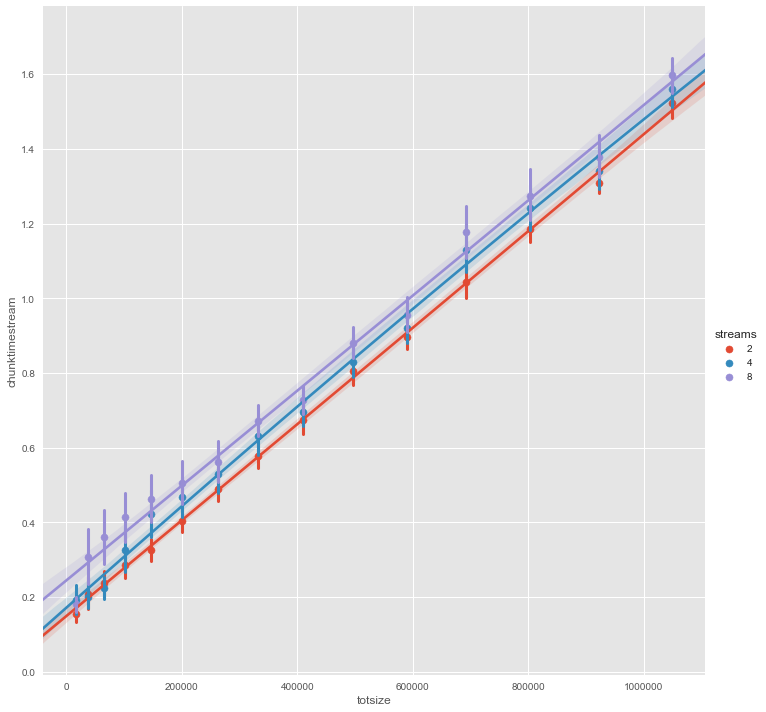

In [129]:
timedf = memcdf.loc[:,('size','cudaMemcpy','chunktimestream','chunkstreams_ nosync','totchunks','streams')]
timedf['totsize'] = timedf['size']*timedf['size']
timedf=timedf.loc[(timedf['totsize']<1100000)]


#seaborn.regplot(y='cudaMemcpy', x='totsize',data=timedf,order=2,x_estimator=np.mean,truncate=True)
#seaborn.regplot(y='chunktimestream', x='totsize',data=timedf, order=2,x_estimator = np.mean,truncate=True)
#seaborn.regplot(y='chunkstreams_ nosync', x='totsize',data=timedf,fit_reg=True, marker="+",x_estimator = np.mean,truncate=True)
seaborn.lmplot(y='chunkstreams_ nosync', x='totsize',order=2,data=timedf,hue='totchunks',size=10,x_estimator=np.mean)
seaborn.lmplot(y='chunktimestream', x='totsize',order=2,data=timedf,hue='streams',size=10,x_estimator=np.mean)



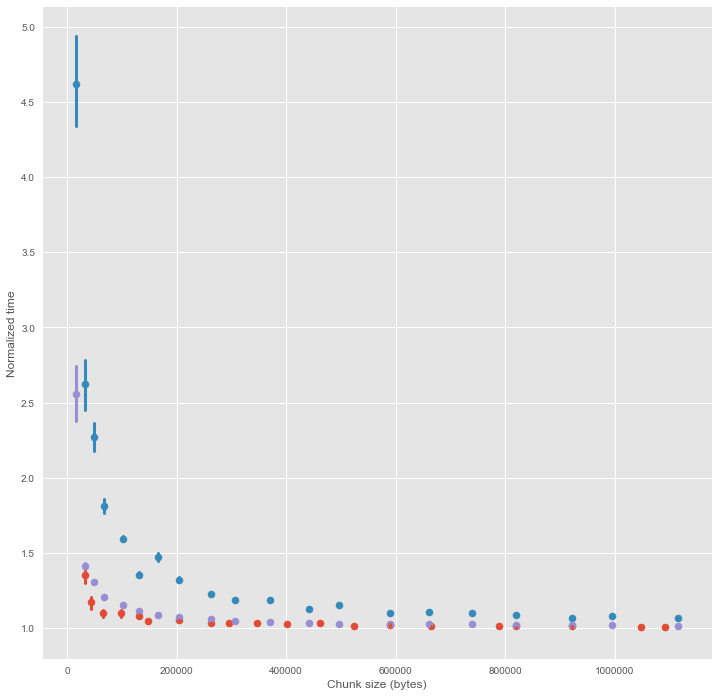

In [98]:
ssc=memcdf.loc[:,('Single Stream Chunking nosync','size','chunkno')]
ssc2=memcdf.loc[:,('size','totchunks','Stream Chunking','Stream Chunking nosync','Stream Chunk size')]
ssc['ssc chunksize']=ssc['size']*ssc['size']*8/ssc['chunkno']
ssc2['ssc chunksize']=ssc2['size']*ssc2['size']*8/(ssc2['totchunks'])
ssc = ssc[ssc['chunkno']>1]
ssc=ssc.loc[(ssc['ssc chunksize']<1200000)]
ssc2=ssc2.loc[(ssc2['ssc chunksize']<1200000)]


#plt.plot(ssc['ssc chunksize'],ssc['Single Stream Chunking nosync'],'r+')
#plt.xlabel('Chunk size (bytes)')
#plt.ylabel('Normalized time')
#plt.title("Chunked transfer in single stream")
#fig=seaborn.FacetGrid(ssc)
fig=seaborn.regplot(y='Single Stream Chunking nosync', x='ssc chunksize',data=ssc,order=2,fit_reg=False,truncate=True,x_bins=20)
fig=seaborn.regplot(y='Stream Chunking', x='ssc chunksize',data=ssc2,order=2,fit_reg=False,truncate=True,x_bins=20)
fig=seaborn.regplot(y='Stream Chunking nosync', x='ssc chunksize',data=ssc2,order=2,fit_reg=False,truncate=True,x_bins=20)
#fig.set_axis_labels('bla','blo')
plt.xlabel('Chunk size (bytes)')
plt.ylabel('Normalized time')
plt.legend(frameon=True)

[0, 1000000, 0, 3.27870781301668]

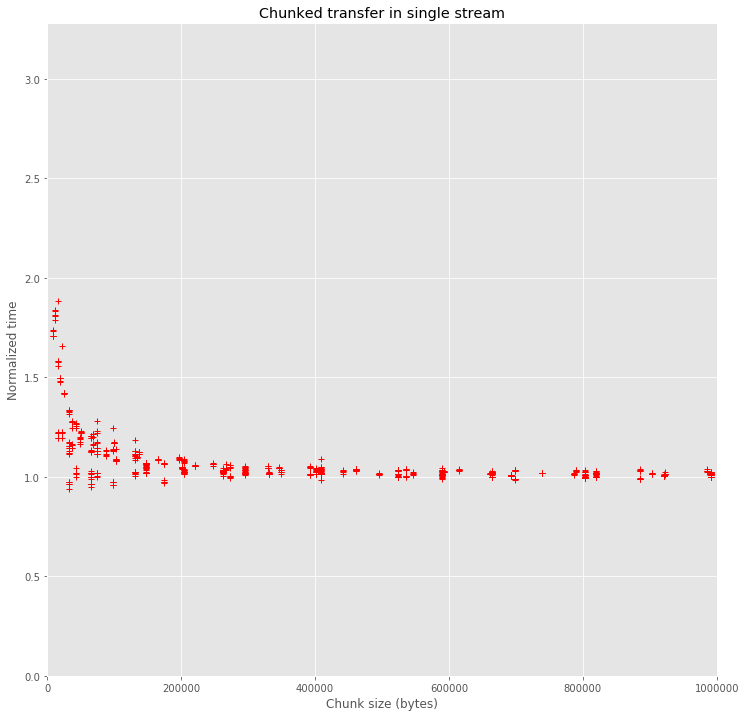

In [7]:
ssc=memcdf.loc[:,('Single Stream Chunking nosync','size','chunkno')]
ssc['ssc chunksize']=ssc['size']*ssc['size']*8/ssc['chunkno']
ssc = ssc[ssc['chunkno']>1]
plt.plot(ssc['ssc chunksize'],ssc['Single Stream Chunking nosync'],'r+')
plt.xlabel('Chunk size (bytes)')
plt.ylabel('Normalized time')
plt.title("Chunked transfer in single stream")
plt.axis([0,1000000,0,memcdf['Single Stream Chunking nosync'].max()])

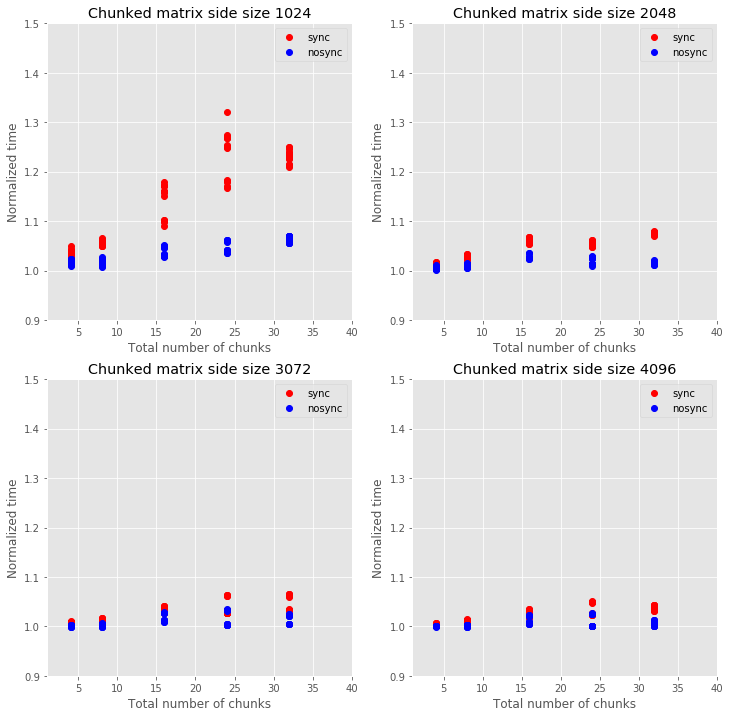

In [34]:
size = [1024,2048,3072,4096]
plt.figure(1)
j = 221
for s in size:
    sizeplot=memcdf[memcdf['size']==s]
    plt.subplot(j)
    plt.plot(sizeplot['totchunks'],sizeplot['Stream Chunking'],'ro',sizeplot['totchunks'],sizeplot['Stream Chunking nosync'],'bo')
    plt.xlabel('Total number of chunks')
    plt.ylabel('Normalized time')
    titel = "Chunked matrix side size " + str(s)
    plt.title(titel)
    plt.legend(['sync','nosync'])
    j+=1
    plt.axis([1,40,0.9,1.5])
plt.show()

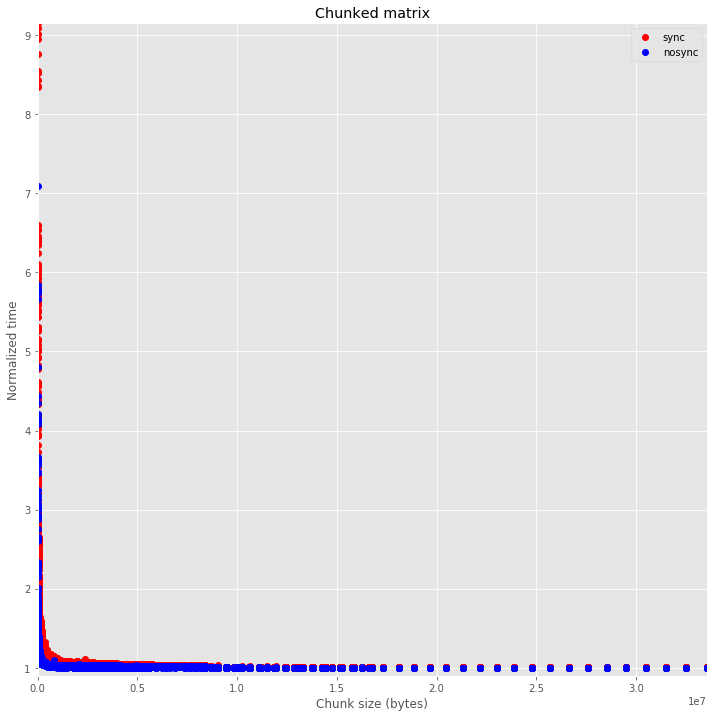

In [35]:
size = [1024,2048,3072,4096]
plt.figure(1)
sizeplot=memcdf
plt.plot(sizeplot['Stream Chunk size'],sizeplot['Stream Chunking'],'ro',sizeplot['Stream Chunk size'],sizeplot['Stream Chunking nosync'],'bo')
plt.xlabel('Chunk size (bytes)')
plt.ylabel('Normalized time')
titel = "Chunked matrix"
plt.title(titel)
plt.legend(['sync','nosync'])
plt.axis([1,sizeplot['Stream Chunk size'].max(),0.9,sizeplot['Stream Chunking'].max()])
plt.show()

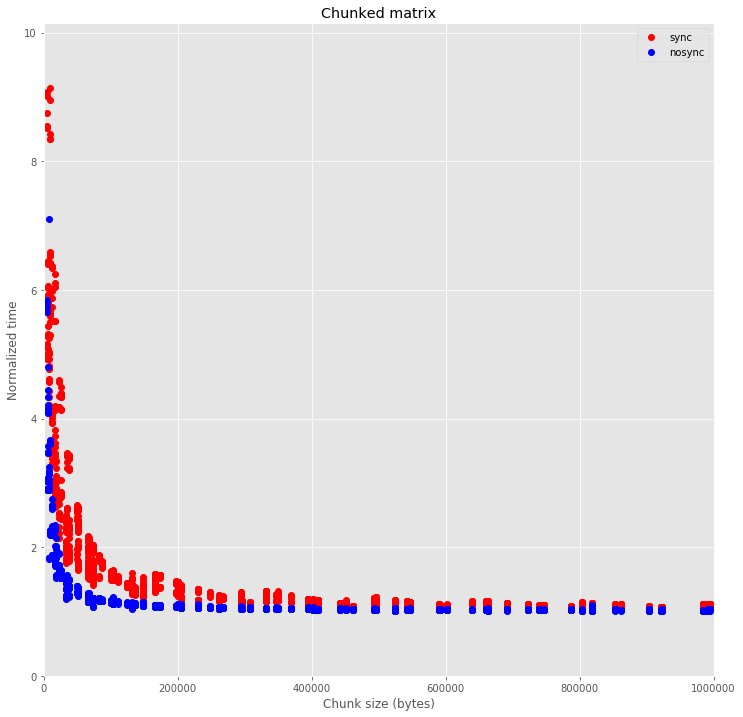

In [42]:
size = [1024,2048,3072,4096]
plt.figure(1)
sizeplot=memcdf

plt.plot(sizeplot['Stream Chunk size'],sizeplot['Stream Chunking'],'ro',sizeplot['Stream Chunk size'],sizeplot['Stream Chunking nosync'],'bo')

plt.xlabel('Chunk size (bytes)')
plt.ylabel('Normalized time')
titel = "Chunked matrix"
plt.title(titel)
plt.legend(['sync','nosync'])
plt.axis([1,1000000,0,sizeplot['Stream Chunking'].max()+1])
plt.show()

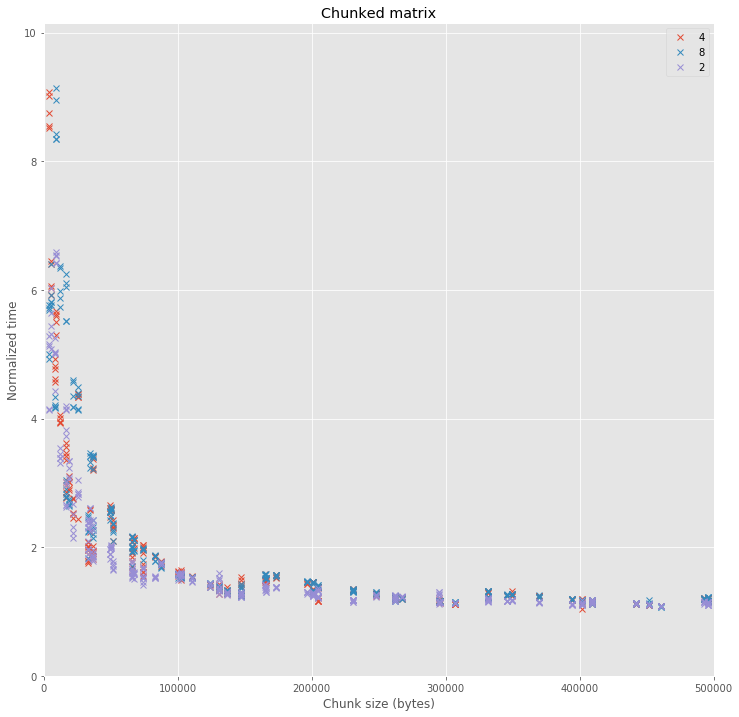

In [40]:
sizeplot=memcdf
no_streams = memcdf['streams'].unique()
for s in no_streams:
    streamplot=memcdf[memcdf['streams']==s]
#plt.plot(sizeplot['Stream Chunk size'],sizeplot['Stream Chunking'],'ro',sizeplot['Stream Chunk size'],sizeplot['Stream Chunking nosync'],'bo')
    plt.plot(streamplot['Stream Chunk size'],streamplot['Stream Chunking'],'x')
plt.xlabel('Chunk size (bytes)')
plt.ylabel('Normalized time')
titel = "Chunked matrix"
plt.title(titel)
plt.legend(no_streams)
plt.axis([1,500000,0,sizeplot['Stream Chunking'].max()+1])
plt.show()

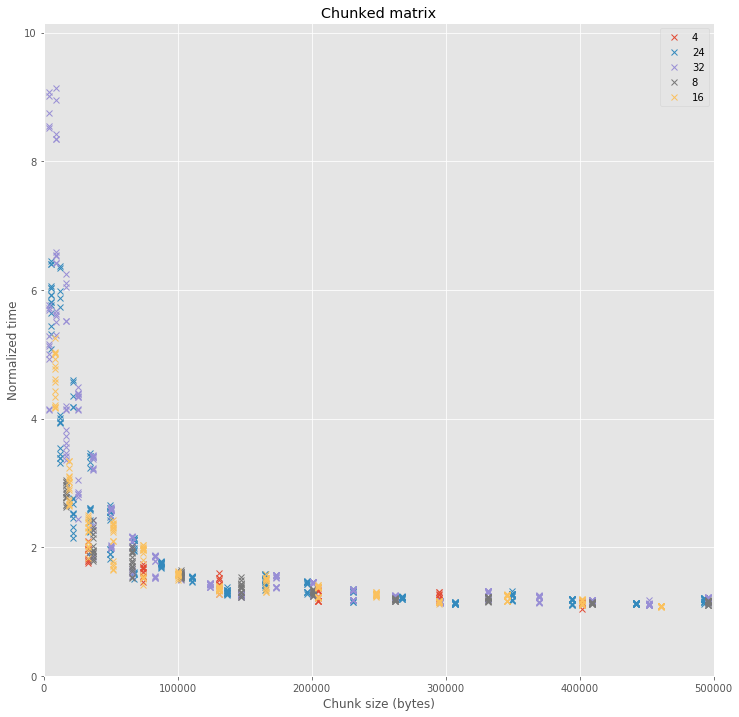

In [41]:
sizeplot=memcdf
no_chunks = memcdf['totchunks'].unique()
for s in no_chunks:
    streamplot=memcdf[memcdf['totchunks']==s]
#plt.plot(sizeplot['Stream Chunk size'],sizeplot['Stream Chunking'],'ro',sizeplot['Stream Chunk size'],sizeplot['Stream Chunking nosync'],'bo')
    plt.plot(streamplot['Stream Chunk size'],streamplot['Stream Chunking'],'x')
plt.xlabel('Chunk size (bytes)')
plt.ylabel('Normalized time')
titel = "Chunked matrix"
plt.title(titel)
plt.legend(no_chunks)
plt.axis([1,500000,0,sizeplot['Stream Chunking'].max()+1])
plt.show()

In [39]:
memcdf[memcdf['Stream Chunking']>6]

,size,dsetmatrix,cudaMemcpy,chunktime,chunk_nosync,chunktimestream,chunkstreams_ nosync,chunkno,chunksize,streams,totchunks,Single Stream Chunking nosync,Stream Chunking,Stream Chunking nosync,Stream Chunk size
315,128,0.053955,0.046875,0.091064,0.047852,0.237793,0.161865,6,5456,4,24,1.221088,6.068006,4.130474,5461.333333
316,128,0.056885,0.041016,0.062012,0.048096,0.252930,0.160889,6,5456,4,24,1.227314,6.454272,4.105568,5461.333333
317,128,0.057129,0.037109,0.062988,0.064941,0.236084,0.174072,6,5456,4,24,1.657165,6.024395,4.441972,5461.333333
319,128,0.062012,0.049805,0.062744,0.046875,0.250977,0.162842,6,5456,4,24,1.196157,6.404435,4.155405,5461.333333
630,128,0.057861,0.047852,0.114258,0.062012,0.353027,0.224854,8,4096,4,32,1.582423,9.008549,5.737828,4096.000000
631,128,0.067871,0.044922,0.086914,0.062012,0.334961,0.227051,8,4096,4,32,1.582423,8.547540,5.793891,4096.000000
632,128,0.052002,0.043945,0.086182,0.073730,0.355957,0.221924,8,4096,4,32,1.881443,9.083316,5.663060,4096.000000
633,128,0.067139,0.045166,0.093018,0.061035,0.333984,0.226074,8,4096,4,32,1.557492,8.522609,5.768960,4096.000000
634,128,0.058105,0.046143,0.087158,0.061768,0.343018,0.229004,8,4096,4,32,1.576197,8.753139,5.843728,4096.000000
1576,128,0.049072,0.036865,0.046875,0.039795,0.250977,0.159912,3,5456,8,24,1.015489,6.404435,4.080637,5461.333333
